In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../PRNet")

from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose
import numpy as np
sys.path.insert(0, "../../deepfeatinterp")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


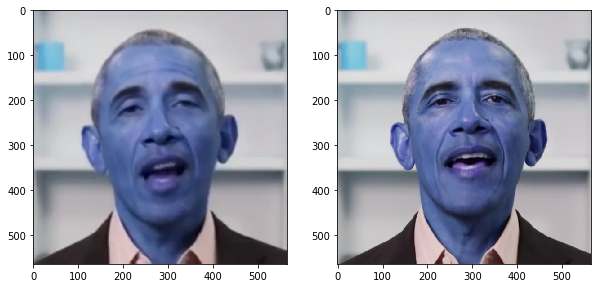

In [2]:
import cv2
# Get one image and list of HD image
im_syn = cv2.imread("/home/vuthede/Desktop/3D/ref/32.png")
im_hd = cv2.imread("/home/vuthede/Desktop/3D/input/16.png")

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(im_syn)
ax[1].imshow(im_hd)



In [3]:
import alignface
import utils
import deepmodels_torch
# import deepmodels

model=deepmodels_torch.vgg19g_torch(device_id='cpu')
# model=deepmodels.vgg19g(device_id=-1)

p_syn = "/home/vuthede/Desktop/3D/ref/32.png"
p_hd = "/home/vuthede/Desktop/3D/input/16.png"
face_d,face_p=alignface.load_face_detector("/home/vuthede/shape_predictor_68_face_landmarks.dat")

lmk, img_syn=alignface.detect_landmarks(p_syn,face_d,face_p)
template,original=alignface.detect_landmarks(p_hd,face_d,face_p)

M, err = alignface.fit_face_landmarks(lmk, template)
img_warp = alignface.warp_to_template(img_syn, M,image_dims=img_syn.shape[:2])
PF=model.mean_F([img_syn])
QF=model.mean_F([template])


IndentationError: unexpected indent (deepmodels_torch.py, line 137)

# Interpolate

In [9]:
import torch
class MyDataSet(torch.utils.data.TensorDataset):
    def __init__(self):
        self.__init__(MyDataSet, torch.utils.data.TensorDataset)
    
    def __getitem__(self, idx):
        return self.data_tensor1(idx)

In [5]:
def fit_submanifold_landmarks_to_image(template,original,Xlm,face_d,face_p,landmarks=list(range(68))):
  '''
  Fit the submanifold to the template and take the top-K.

  Xlm is a N x 68 x 2 list of landmarks.
  '''
  lossX=numpy.empty((len(Xlm),),dtype=numpy.float64)
  MX=numpy.empty((len(Xlm),2,3),dtype=numpy.float64)
  nfail=0
  for i in range(len(Xlm)):
    lm=Xlm[i]
    try:
      M,loss=alignface.fit_face_landmarks(Xlm[i],template,landmarks=landmarks,image_dims=original.shape[:2])
      lossX[i]=loss
      MX[i]=M
    except alignface.FitError:
      lossX[i]=float('inf')
      MX[i]=0
      nfail+=1
  if nfail>1:
    print('fit submanifold, {} errors.'.format(nfail))
  a=numpy.argsort(lossX)
  return a,lossX,MX

